In [1]:
%matplotlib inline
import sys
from u8timeseries import Prophet, KthValueAgoBaseline, ExponentialSmoothing, TimeSeries, Arima, AutoArima
from u8timeseries import StandardRegressiveModel
from u8timeseries.metrics import mape, overall_percentage_error, mase
from u8timeseries.backtesting import simulate_forecast_ar, simulate_forecast_regr, get_train_val_series, backtest_autoregressive_model
from u8timeseries.models.statistics import check_seasonality, plot_acf

import pandas as pd
pd.__version__
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt

/home/new/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


## Read data

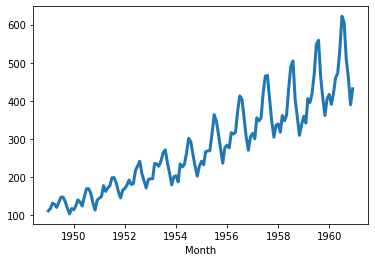

In [2]:
df = pd.read_csv('AirPassengers.csv', delimiter=",")
series = TimeSeries.from_dataframe(df, 'Month', '#Passengers')
series.plot(lw=3)

## Exploration

Before building any kind of model, it is good to understand the characteristics of our TimeSeries.

For example, the Air Passenger data seems to have a seasonal trend, with a yearly period. 
The existence of such a trend can be explored using the auto-correlation function (ACF).

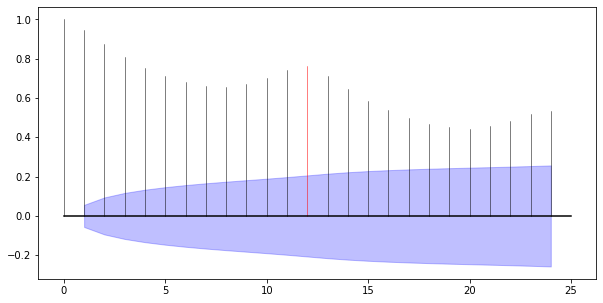

In [3]:
plot_acf(series, m = 12, alpha = .05)

The ACF presents a spike at x = 12, which suggests a yearly seasonality trend (highlighted in red). The dotted blue lines display the confidence level for alpha = 5%.

Even working with this very well-known case, one can see that the x = 11 value of the ACF is quite close to being a local maximum. Thus is it is useful to have a statistical check of seasonality against a particular value of the period m.

In [4]:
for i in range(1, 13):
    season, period = check_seasonality(series, m = i, alpha = .05)
    
    if season:
        print('There is seasonality of order {}.'.format(period))
    else:
        print('There is no seasonality of order {}.'.format(period))

There is no seasonality of order 1.
There is no seasonality of order 2.
There is no seasonality of order 3.
There is no seasonality of order 4.
There is no seasonality of order 5.
There is no seasonality of order 6.
There is no seasonality of order 7.
There is no seasonality of order 8.
There is no seasonality of order 9.
There is no seasonality of order 10.
There is no seasonality of order 11.
There is seasonality of order 12.


A stastical check confirms our intuition!

## Build three models

In [5]:
model_es = ExponentialSmoothing()
model_pr = Prophet()
model_ar = Arima(2, 1, 5)
model_bl = KthValueAgoBaseline(K=12)

## Try one of the models
Here we'll just do a one shot prediction. Prediction time will be 1957-01-01, and we'll forecast the rest of the time series from that point on.

Definition: *prediction time* is the time *at which* a forecast is made, and *forecast time* is the time *for which* the forecast is made.

For instance, in the example below, prediction time is 1957-01-01, and forecast time is the time range between 1957-02-01 and the end of the time series.

In [6]:
train, val = series.split_after(pd.Timestamp('19570101'))
model_es.fit(train)
pred = model_es.predict(len(val))

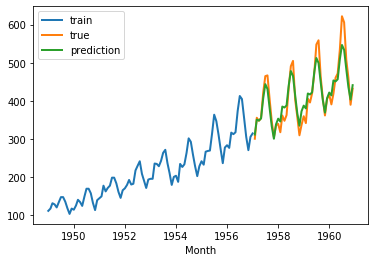

In [7]:
train.plot(lw=2, label='train')
val.plot(lw=2, label='true')
pred.plot(lw=2, label='prediction')
plt.legend()

## Simulate historical forecasting
Here we'll do some backtesting. We will simulate predictions that would have been done historically with a given model. It can take a while to produce, since the model is re-fit every time the simulated prediction time advances.

Such simulated forecasts are always defined with respect to a *forecast horizon*, which is the number of time steps that separate the prediction time from the forecast time. In the example below, we simulate forecasts done for 6 months in the future (compared to prediction time).

In [8]:
historical_fcast = simulate_forecast_ar(series, model_es, pd.Timestamp('19570101'), fcast_horizon_n=6, verbose=True)

Let's see what this backtest forecast looks like. You can see it produces more accurate predictions than the one-off prediction done above, because here the model is re-fit every month.

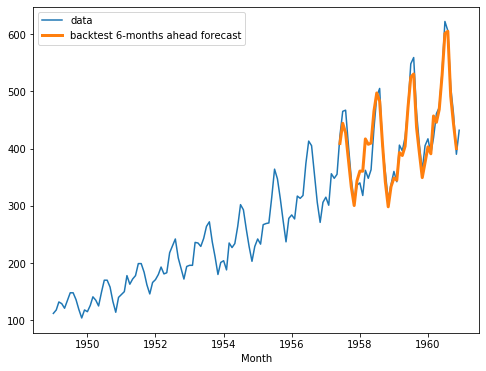

In [9]:
plt.figure(figsize=(8,6))
series.plot(label='data')
historical_fcast.plot(lw=3, label='backtest 6-months ahead forecast')
plt.legend()

## Backtest the models on the data using a user-defined metric
Here we'll do slightly more advanced backtesting, and use our own metric (in this case the MAPE error function) to compare the different models. We'll simulate 12-months ahead predictions done in the past, starting in January 1955, and the errors will be computed on the 12-months period for which forecasts are done.

In [10]:
def backtest_model(model):
    tic = time.time()
    train_val_series = get_train_val_series(series, start=pd.Timestamp('19550101'), nr_points_val=12)
    res = backtest_autoregressive_model(model, train_val_series, mape)
    tac = time.time()
    print('Backtest done in %.2f s.' % (tac-tic))
    return res

In [11]:
res_es = backtest_model(model_es)
res_pr = backtest_model(model_pr)
res_bl = backtest_model(model_bl)

Backtest done in 44.35 s.


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Backtest done in 104.88 s.
Backtest done in 0.31 s.


### Plot the user-defined backtesting results

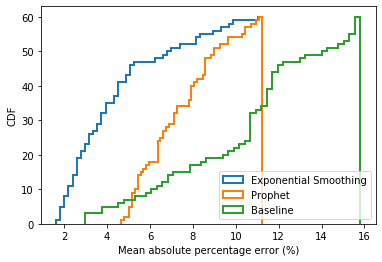

In [12]:
plt.hist(res_es, bins=50, cumulative=True, histtype='step', 
         lw=2, label='Exponential Smoothing');
plt.hist(res_pr, bins=50, cumulative=True, histtype='step', 
         lw=2, label='Prophet');
plt.hist(res_bl, bins=50, cumulative=True, histtype='step', 
         lw=2, label='Baseline');

plt.xlabel('Mean absolute percentage error (%)')
plt.ylabel('CDF')
plt.legend(loc=4)

### Let's make an actual forecast!
Since Exponential Smoothing is better in backtests, let's use this one.

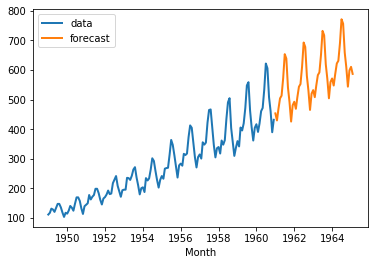

In [13]:
model_es.fit(series)
pred = model_es.predict(n = 50)

series.plot(label='data', lw=2)
pred.plot(label='forecast', lw=2)
plt.legend()

## Ensembling several predictions
### Let's simulate forecasts done by an ensemble of models

In [14]:
""" New way - backtest over time
"""
models = [ExponentialSmoothing(), Prophet()]

historical_ar_preds = [simulate_forecast_ar(series, m, pd.Timestamp('19570101'), fcast_horizon_n=6, verbose=True)
                       for m in models]

In [15]:
""" Combine the individual simulated predicitons
"""
regrModel = StandardRegressiveModel(train_n_points=12)

series_val = series.intersect(historical_ar_preds[0])

historical_pred = simulate_forecast_regr(historical_ar_preds, series_val, regrModel,
                                         pd.Timestamp('19580101'), fcast_horizon_n=6)

.............................

MAPE Error Exponential smoothing: 3.096856614366349
MAPE Error Prophet: 7.3179601627698725
MAPE Error ensemble: 5.847406449273073


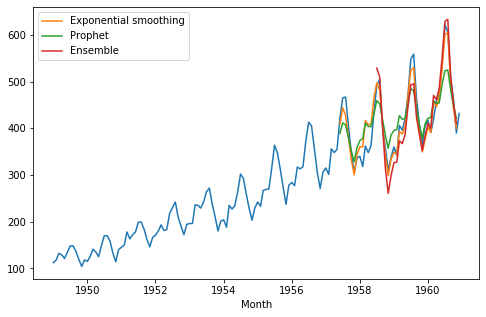

In [16]:
""" Compute errors and plot
"""
plt.figure(figsize=(8,5))

series.plot()
for i, m in enumerate(models):
    historical_ar_preds[i].plot(label=str(m))
    
    # intersect last part, to compare everything with ensemble
    ar_pred = historical_ar_preds[i].intersect(historical_pred)
       
    mape_er = mape(series.intersect(historical_pred), ar_pred)
    print('MAPE Error {}: {}'.format(m, mape_er))

print('MAPE Error ensemble: {}'.format(mape(series.intersect(historical_pred), historical_pred)))

historical_pred.plot(label='Ensemble')

plt.legend()

## Example of forecasting using a regressive model and extra features